In [1]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
from scipy.interpolate import interp1d
from utils import *
import random
import pickle
from bokeh.plotting import figure, show
from itertools import groupby
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LinearAxis, Range1d, HoverTool

#### Data Loading

In [2]:
### Load data
df_precp_10yr = pd.read_pickle('df_precp_10yr.pkl')

df_precp_10yr = df_precp_10yr.rename(columns={"precp": "original_precp"})
df_precp_10yr = df_precp_10yr.rename(columns={"precp2" : "precp"})

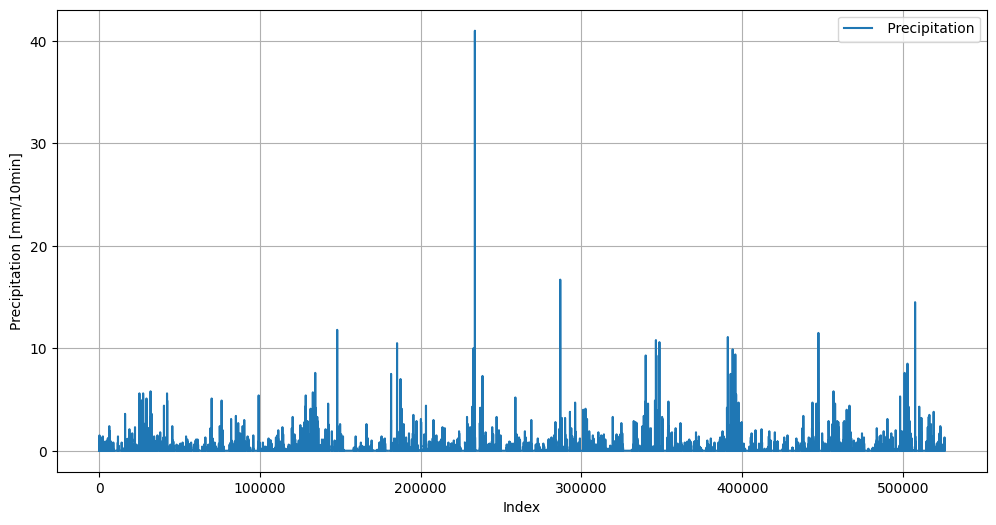

In [3]:
# Plot the 'original_precp' column
plt.figure(figsize=(12, 6))
plt.plot(df_precp_10yr['original_precp'], linestyle='-', label=' Precipitation')
plt.xlabel('Index')
plt.ylabel('Precipitation [mm/10min]')
plt.legend()
plt.grid(True)
plt.show()

In [4]:

original_series = df_precp_10yr['original_precp']

# Split the series into 3 equal (or nearly equal) parts using np.array_split
parts = np.array_split(original_series, 3)

# Now, switch the second and third parts
# parts[0] remains, then parts[2] comes next, and finally parts[1]
switched_series = pd.concat([parts[0], parts[1],parts[2]]).reset_index(drop=True)


df_precp_10yr['switched_original_precp'] = switched_series

# To verify the result, you might want to inspect the head and tail of the new column
print(len(df_precp_10yr['switched_original_precp']))

525888


/opt/jlab-env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


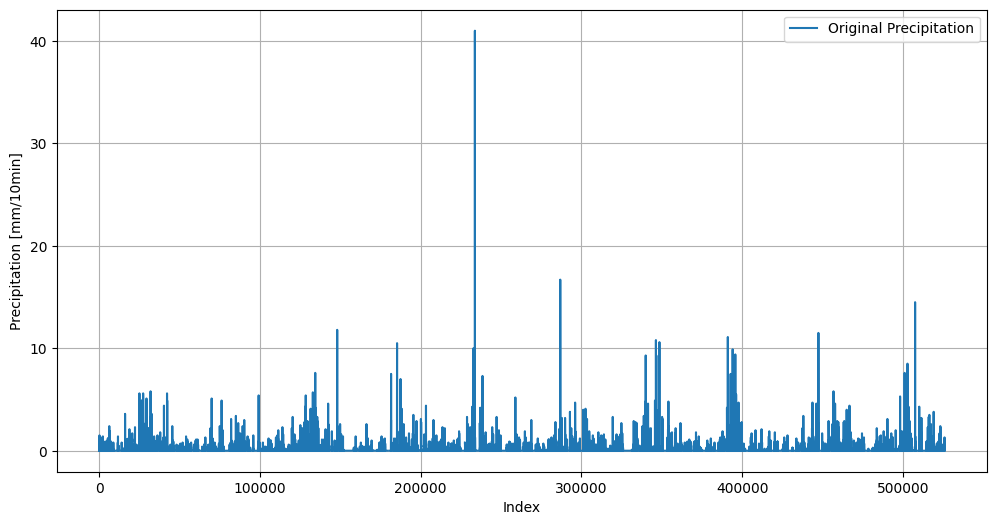

In [5]:
# We switch the 2nd and 3rd part
plt.figure(figsize=(12, 6))
plt.plot(df_precp_10yr['switched_original_precp'], linestyle='-', label='Original Precipitation')
plt.xlabel('Index')
plt.ylabel('Precipitation [mm/10min]')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Define number of points in the window
nbr_of_windows = 10
tau = round(len(df_precp_10yr['switched_original_precp']) / nbr_of_windows)
print("Tau:", tau)

# Calculate the mean for the window (using indices 1:tau)
mean_precip = df_precp_10yr['switched_original_precp'].iloc[1:tau].mean()

# Convert the series for the window to a NumPy array
x = df_precp_10yr['switched_original_precp'].iloc[:tau].to_numpy()

# Compute deviations from the mean
d = x - mean_precip

# Compute the cumulative sum from i to tau using a reversed cumulative sum:
# This computes Xi[i] = sum(d[i:tau])
xi = np.cumsum(d[::-1])[::-1]

# If you want to store these Xi values back into your DataFrame for the first tau points:
df_precp_10yr = df_precp_10yr.copy()  # Make a copy to avoid chained indexing issues
df_precp_10yr.loc[:tau-1, 'Xi'] = xi

# Now compute reservoir size, standard deviation, and Hurst exponent
vol_tank1 = np.max(xi) - np.min(xi)
std1 = np.std(xi, ddof=1)  # sample standard deviation
hurst1 = vol_tank1 / std1

print("vol_tank1 =", vol_tank1)
print("std1 =", std1)
print("hurst1 =", hurst1)


Tau: 52589
vol_tank1 = 166.57619899564145
std1 = 41.69323633575563
hurst1 = 3.9952810967755856


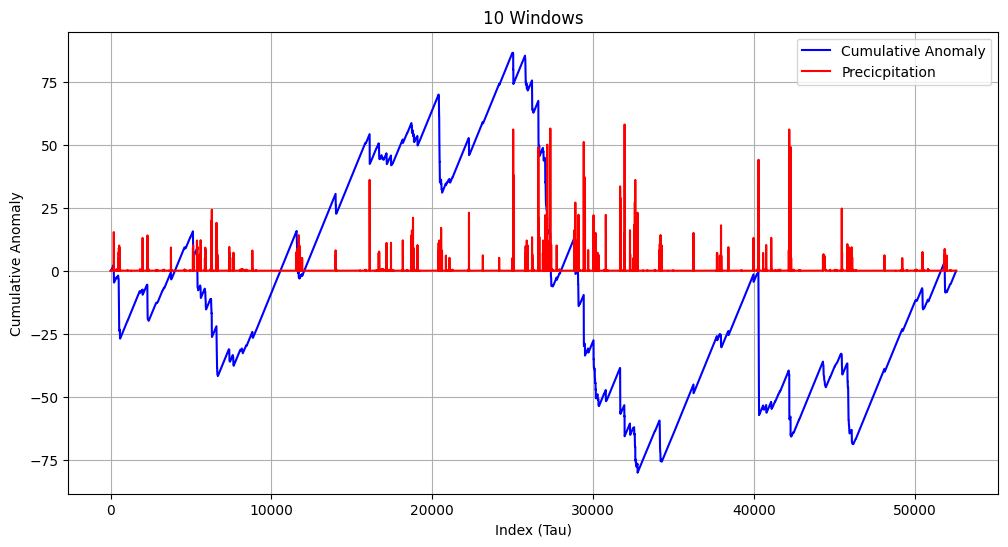

In [7]:
# Plot
mean_precipitation = df_precp_10yr['switched_original_precp'].iloc[:tau].mean()

plt.figure(figsize=(12, 6))
plt.plot(df_precp_10yr['Xi'].iloc[:tau], linestyle='-', color='blue', label='Cumulative Anomaly')
plt.plot(df_precp_10yr['switched_original_precp'].iloc[:tau]*10, linestyle='-', color='red', label='Precicpitation')

#plt.axhline(y=mean_precipitation*10, color='green', linestyle='--', label='Mean Precipitation')

plt.xlabel('Index (Tau)')
plt.ylabel('Cumulative Anomaly')
plt.title('10 Windows')
plt.legend()
plt.grid(True)
plt.show()

#### Hurst of the original Rainfall - 10 years  

Window size 52589: avg R/S = 1161.153
Window size 78883: avg R/S = 1457.805
Window size 105177: avg R/S = 1665.309
Window size 131472: avg R/S = 1897.898
Window size 157766: avg R/S = 1931.752
Window size 184060: avg R/S = 2072.898
Window size 210355: avg R/S = 2181.331
Window size 236649: avg R/S = 2305.576
Window size 262944: avg R/S = 2457.544
Window size 289238: avg R/S = 2576.025
Window size 315532: avg R/S = 2657.960
Window size 341827: avg R/S = 2730.859
Window size 368121: avg R/S = 2786.263
Window size 394416: avg R/S = 2886.965
Window size 420710: avg R/S = 2894.733
Window size 447004: avg R/S = 2896.988
Window size 473299: avg R/S = 2886.901
Window size 499593: avg R/S = 2916.164
Window size 525888: avg R/S = 3279.956

Estimated Hurst exponent (H): 0.413


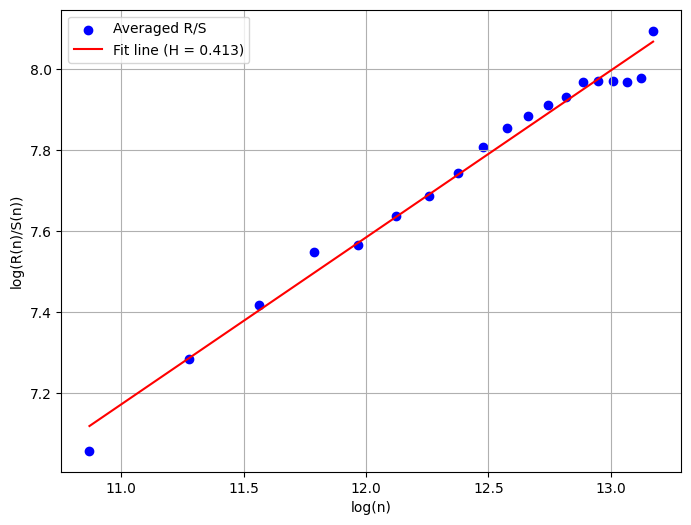

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress


switched_series = df_precp_10yr['switched_original_precp']
n_total = len(switched_series)

# Define a function that computes the average R/S for a given window size n using overlapping segments
def average_rs(series, n, step=1):
    rs_vals = []
    # Slide a window of length n along the series with a given step
    for start in range(0, len(series) - n + 1, step):
        segment = series.iloc[start:start+n]
        mean_seg = segment.mean()
        # Compute forward cumulative sum of deviations from the mean
        cum_dev = (segment - mean_seg).cumsum()
        R_n = cum_dev.max() - cum_dev.min()
        S_n = segment.std(ddof=1)
        if S_n > 0:
            rs_vals.append(R_n / S_n)
    return np.mean(rs_vals) if rs_vals else np.nan

# Choose window sizes
min_window = 10
window_sizes = np.floor(np.linspace(round(n_total/min_window), n_total, 19)).astype(int)

# Use an appropriate step for overlapping segments (smaller step gives more averaging)
step = max(1, n_total // 100)  

avg_rs_values = []
valid_sizes = []

for n in window_sizes:
    if n < 2:
        continue
    rs_val = average_rs(switched_series, n, step=step)
    if not np.isnan(rs_val):
        avg_rs_values.append(rs_val)
        valid_sizes.append(n)
        print(f"Window size {n}: avg R/S = {rs_val:.3f}")

# Convert to logarithmic values
log_n = np.log(valid_sizes)
log_rs = np.log(avg_rs_values)

# Linear regression on the log-log values to estimate the Hurst exponent
slope, intercept, r_value, p_value, std_err = linregress(log_n, log_rs)
H_est = slope
print(f"\nEstimated Hurst exponent (H): {H_est:.3f}")

# Plot the log-log plot and regression line
plt.figure(figsize=(8, 6))
plt.scatter(log_n, log_rs, color='blue', label='Averaged R/S')
plt.plot(log_n, intercept + slope * log_n, color='red', label=f'Fit line (H = {H_est:.3f})')
plt.xlabel('log(n)')
plt.ylabel('log(R(n)/S(n))')
plt.legend()
plt.grid(True)
plt.show()

#### Hurst of the rainfall - 5 years

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the time series (assumes `df_precp_10yr` contains the column)
switched_series = df_precp_10yr['switched_original_precp']
n_total = len(switched_series)

# --- Vectorized R/S Calculation ---
def average_rs_vectorized(series, n, step=1):
    """
    Compute the average R/S for a window of length n using vectorized operations.
    
    Parameters:
      series: Pandas Series of data.
      n: Window length (number of data points).
      step: Step size between windows.
      
    Returns:
      The average R/S computed over all overlapping segments.
    """
    arr = series.to_numpy()
    total_length = len(arr)
    num_windows = (total_length - n) // step + 1
    if num_windows < 1:
        return np.nan
    
    # Create a 2D view of overlapping segments
    shape = (num_windows, n)
    strides = (arr.strides[0] * step, arr.strides[0])
    windows = np.lib.stride_tricks.as_strided(arr, shape=shape, strides=strides)
    
    means = windows.mean(axis=1, keepdims=True)
    deviations = windows - means
    cumsum_dev = np.cumsum(deviations, axis=1)
    
    R_vals = cumsum_dev.max(axis=1) - cumsum_dev.min(axis=1)
    S_vals = windows.std(axis=1, ddof=1)
    
    valid = S_vals > 0
    if not np.any(valid):
        return np.nan
    
    RS_vals = R_vals[valid] / S_vals[valid]
    return RS_vals.mean()

# --- Define Window Sizes ---
min_window = 10
window_sizes = np.floor(np.linspace(round(n_total/min_window), n_total//5, 10)).astype(int)

# --- Set Step Size ---
step = max(1, n_total // 100)  # Ensure enough windows for averaging

# --- Compute R/S Values for Different Window Sizes ---
avg_rs_values = []
valid_sizes = []

for n in window_sizes:
    if n < 2:
        continue
    rs_val = average_rs_vectorized(switched_series, n, step=step)
    if not np.isnan(rs_val):
        avg_rs_values.append(rs_val)
        valid_sizes.append(n)
        print(f"Window size {n}: avg R/S = {rs_val:.3f}")

# --- Perform Log-Log Linear Regression ---
log_n = np.log(valid_sizes)
log_rs = np.log(avg_rs_values)

slope, intercept, r_value, p_value, std_err = linregress(log_n, log_rs)
H_est = slope
print(f"\nEstimated Hurst exponent (H): {H_est:.3f}")

# --- Plot the Log-Log Regression ---
plt.figure(figsize=(8, 6))
plt.scatter(log_n, log_rs, color='blue', label='Averaged R/S')
plt.plot(log_n, intercept + slope * log_n, color='red', label=f'Fit line (H = {H_est:.3f})')
plt.xlabel('log(n)')
plt.ylabel('log(R(n)/S(n))')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Plot Xi for each valid window size in a grid of subplots
n_plots = len(valid_sizes)
ncols = 2
nrows = (n_plots + ncols - 1) // ncols  # Round up number of rows

plt.figure(figsize=(15, nrows * 4))

for i, n in enumerate(valid_sizes):
    segment = switched_series.iloc[:n]
    mean_seg = segment.mean()
    xi = (segment - mean_seg).cumsum()
    plt.subplot(nrows, ncols, i+1)
    plt.plot(xi, linestyle='-', color='blue')
    plt.title(f'Window Size: {n}')
    plt.xlabel('Index')
    plt.ylabel('Xi')
    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
valid_sizes

### First try on the Hurst Analysis for the Qout

In [52]:
combined_Qout = pd.read_pickle('combined_Qout.pkl')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# --- Function to compute average R/S using vectorized operations ---
def average_rs_vectorized(series, n, step=1):
    """
    Compute the average R/S for a window of length n using vectorized operations.
    
    Parameters:
      series: Pandas Series of data.
      n: Window length (number of data points).
      step: Step size between windows.
      
    Returns:
      The average R/S computed over all overlapping segments.
    """
    arr = series.to_numpy()
    total_length = len(arr)
    num_windows = (total_length - n) // step + 1
    if num_windows < 1:
        return np.nan
    # Create a 2D view of overlapping segments
    shape = (num_windows, n)
    strides = (arr.strides[0] * step, arr.strides[0])
    windows = np.lib.stride_tricks.as_strided(arr, shape=shape, strides=strides)
    
    means = windows.mean(axis=1, keepdims=True)
    deviations = windows - means
    cumsum_dev = np.cumsum(deviations, axis=1)
    
    R_vals = cumsum_dev.max(axis=1) - cumsum_dev.min(axis=1)
    S_vals = windows.std(axis=1, ddof=1)
    valid = S_vals > 0
    if not np.any(valid):
        return np.nan
    RS_vals = R_vals[valid] / S_vals[valid]
    return RS_vals.mean()

# --- Restrict analysis to the first 5 years (half of the data) ---
# combined_Qout is assumed to be your DataFrame with 4 columns.
# We take only the first half of the rows.
data_5yr = combined_Qout.iloc[:len(combined_Qout)//2]
n_total_5 = len(data_5yr)
print(f"Length of 5-year data: {n_total_5}")

# --- Define window sizes ---
# We'll use 10 window sizes, from 10% of the 5-year data up to 100% of it.
fractions = np.linspace(0.2, 1.0, 5)
window_sizes = np.floor(fractions * n_total_5).astype(int)

# --- Set up plot ---
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'purple']

# --- Loop over the 4 columns and compute Hurst exponent ---
for i, col in enumerate(data_5yr.columns):
    series = data_5yr[col]
    
    avg_rs_values = []
    valid_sizes = []
    
    # Choose a step that is small enough to get enough windows.
    # Here we set step = max(1, n_total_5//1000)
    step = max(1, n_total_5 // 500)
    
    for n in window_sizes:
        if n < 2:
            continue
        rs_val = average_rs_vectorized(series, n, step=step)
        if not np.isnan(rs_val):
            avg_rs_values.append(rs_val)
            valid_sizes.append(n)
            print(f"Column {col} - Window size {n}: avg R/S = {rs_val:.3f}")
    
    # Convert to logarithms for regression
    log_n = np.log(valid_sizes)
    log_rs = np.log(avg_rs_values)
    
    # Perform linear regression on the log-log data
    slope, intercept, r_value, p_value, std_err = linregress(log_n, log_rs)
    H_est = slope
    print(f"Column {col} - Estimated Hurst exponent (H): {H_est:.3f}")
    
    # Plot the data points and regression line for this column
    plt.scatter(log_n, log_rs, color=colors[i], label=f'{col} data')
    plt.plot(log_n, intercept + slope * log_n, color=colors[i],
             linestyle='--', label=f'{col} fit (H={H_est:.3f})')

plt.xlabel('log(window size)')
plt.ylabel('log(R(n)/S(n))')
plt.title('Rescaled Range Analysis - Hurst Exponent for 5 Years (4 Columns)')
plt.legend()
plt.grid(True)
plt.savefig("Hurst1.png", dpi=300, bbox_inches="tight")

plt.show()


A tank in the system creates a **moderate memory effect** by making the outflow smoother and less random. This is shown by the **Hurst exponent (H)** increasing from **0.436 (no tank) to 0.485 (300m³ tank)**, meaning that past values have more influence on future values as the tank gets bigger. Without a tank, the outflow changes quickly and returns to the average fast. With a tank, the flow is **more stable**, as the tank **stores and releases water slowly**, reducing sudden changes. However, since **H is still below 0.5**, the effect is **not very strong**, but it does help to make the flow more predictable. This can be useful for **controlling water flow, reducing peaks, and improving water supply stability**. Even small tanks can make a noticeable difference.

In [33]:
combined_Qout = pd.read_pickle('combined_Qout_2.pkl')

Length of 5-year data: 105177
Column Qout_notank - Window size 10517: avg R/S = 776.383
Column Qout_notank - Window size 21035: avg R/S = 1215.526
Column Qout_notank - Window size 31553: avg R/S = 1514.138
Column Qout_notank - Window size 42070: avg R/S = 1616.885
Column Qout_notank - Window size 52588: avg R/S = 1791.176
Column Qout_notank - Window size 63106: avg R/S = 1861.484
Column Qout_notank - Window size 73623: avg R/S = 2055.429
Column Qout_notank - Window size 84141: avg R/S = 2271.994
Column Qout_notank - Window size 94659: avg R/S = 2450.866
Column Qout_notank - Window size 105177: avg R/S = 2527.554
Column Qout_notank - Estimated Hurst exponent (H): 0.487
Column Qout_100 - Window size 10517: avg R/S = 811.532
Column Qout_100 - Window size 21035: avg R/S = 1324.443
Column Qout_100 - Window size 31553: avg R/S = 1679.602
Column Qout_100 - Window size 42070: avg R/S = 1823.993
Column Qout_100 - Window size 52588: avg R/S = 2019.295
Column Qout_100 - Window size 63106: avg R/S

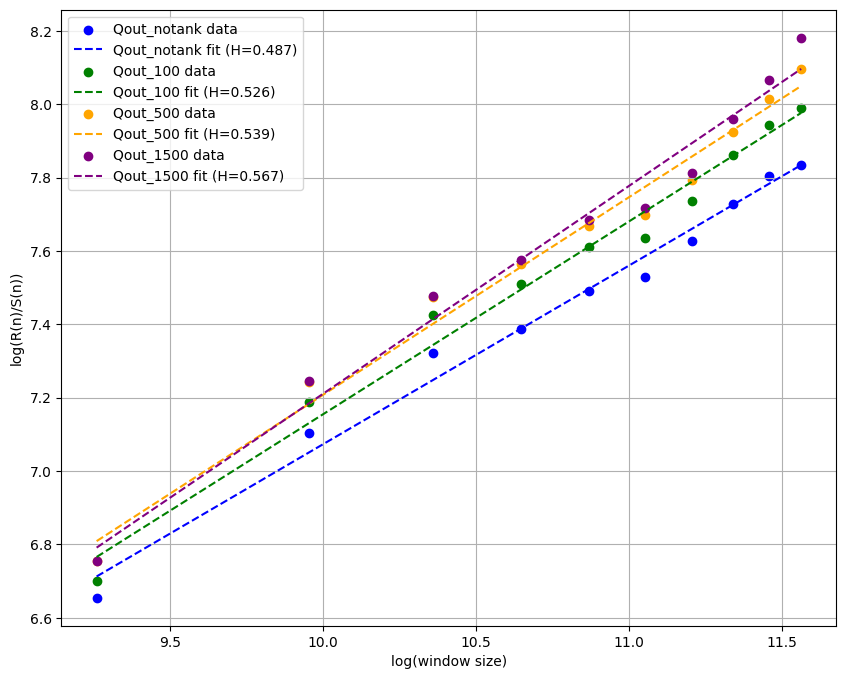

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# --- Function to compute average R/S using vectorized operations ---
def average_rs_vectorized(series, n, step=1):
    """
    Compute the average R/S for a window of length n using vectorized operations.
    
    Parameters:
      series: Pandas Series of data.
      n: Window length (number of data points).
      step: Step size between windows.
      
    Returns:
      The average R/S computed over all overlapping segments.
    """
    arr = series.to_numpy()
    total_length = len(arr)
    num_windows = (total_length - n) // step + 1
    if num_windows < 1:
        return np.nan
    # Create a 2D view of overlapping segments
    shape = (num_windows, n)
    strides = (arr.strides[0] * step, arr.strides[0])
    windows = np.lib.stride_tricks.as_strided(arr, shape=shape, strides=strides)
    
    means = windows.mean(axis=1, keepdims=True)
    deviations = windows - means
    cumsum_dev = np.cumsum(deviations, axis=1)
    
    R_vals = cumsum_dev.max(axis=1) - cumsum_dev.min(axis=1)
    S_vals = windows.std(axis=1, ddof=1)
    valid = S_vals > 0
    if not np.any(valid):
        return np.nan
    RS_vals = R_vals[valid] / S_vals[valid]
    return RS_vals.mean()

# --- Restrict analysis to the first 5 years (half of the data) ---
# combined_Qout is assumed to be your DataFrame with 4 columns.
# We take only the first half of the rows.
data_5yr = combined_Qout.iloc[:len(combined_Qout)//5]
n_total_5 = len(data_5yr)
print(f"Length of 5-year data: {n_total_5}")

# --- Define window sizes ---
# We'll use 10 window sizes, from 10% of the 5-year data up to 100% of it.
fractions = np.linspace(0.1, 1.0, 10)
window_sizes = np.floor(fractions * n_total_5).astype(int)

# --- Set up plot ---
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'purple']

# --- Loop over the 4 columns and compute Hurst exponent ---
for i, col in enumerate(data_5yr.columns):
    series = data_5yr[col]
    
    avg_rs_values = []
    valid_sizes = []
    
    # Choose a step that is small enough to get enough windows.
    # Here we set step = max(1, n_total_5//1000)
    step = max(1, n_total_5 // 100)
    
    for n in window_sizes:
        if n < 2:
            continue
        rs_val = average_rs_vectorized(series, n, step=step)
        if not np.isnan(rs_val):
            avg_rs_values.append(rs_val)
            valid_sizes.append(n)
            print(f"Column {col} - Window size {n}: avg R/S = {rs_val:.3f}")
    
    # Convert to logarithms for regression
    log_n = np.log(valid_sizes)
    log_rs = np.log(avg_rs_values)
    
    # Perform linear regression on the log-log data
    slope, intercept, r_value, p_value, std_err = linregress(log_n, log_rs)
    H_est = slope
    print(f"Column {col} - Estimated Hurst exponent (H): {H_est:.3f}")
    
    # Plot the data points and regression line for this column
    plt.scatter(log_n, log_rs, color=colors[i], label=f'{col} data')
    plt.plot(log_n, intercept + slope * log_n, color=colors[i],
             linestyle='--', label=f'{col} fit (H={H_est:.3f})')

plt.xlabel('log(window size)')
plt.ylabel('log(R(n)/S(n))')
#plt.title('Rescaled Range Analysis - Hurst Exponent for 5 Years (4 Columns)')


plt.legend()
plt.grid(True)
plt.savefig("Hurst2.png", dpi=300, bbox_inches="tight")
plt.show()


these results clearly show that increasing tank size has a strong effect on **outflow stability**. The **Hurst exponent (H)** increases from **0.436 (no tank) to 0.507 (1500m³ tank)**, meaning that larger tanks create a **stronger memory effect**. Without a tank, the outflow reacts quickly to inflow changes, showing **more randomness and short-term corrections**. With a **small tank (100m³),** the flow is smoother but still fluctuates. However, with **larger tanks (500m³ and 1500m³),** past outflow values have a **greater influence on future values**, making the system more **stable and persistent**. The increase in **R/S values** also confirms this trend. Interestingly, the effect slows down with size, meaning that **after a certain point, adding more storage has less impact**. These results clearly show that storage tanks **reduce variability and create long-term stability**, which is important for **water management and flow regulation**.

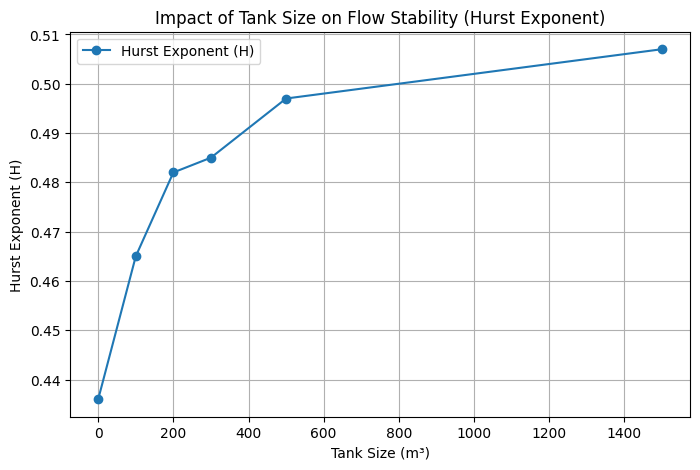

In [58]:
# Tank sizes (m³)
tank_sizes = np.array([0, 100,200,300, 500, 1500])

# Corresponding Hurst exponent values
hurst_values = np.array([0.436, 0.465,0.482,0.485, 0.497, 0.507])

# Plot Cost vs. Hurst exponent
plt.figure(figsize=(8, 5))
plt.plot(tank_sizes, hurst_values, marker='o', linestyle='-', label="Hurst Exponent (H)")
plt.xlabel("Tank Size (m³)")
plt.ylabel("Hurst Exponent (H)")
plt.title("Impact of Tank Size on Flow Stability (Hurst Exponent)")
plt.grid(True)
plt.legend()
plt.show()


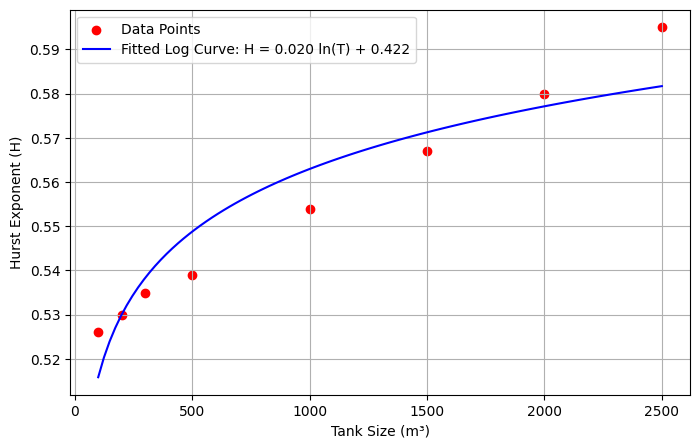

Fitted equation: H = 0.020 ln(T) + 0.422


In [46]:
from scipy.optimize import curve_fit

# New data points
tank_sizes = np.array([100, 200, 300, 500,1000, 1500,2000,2500])
hurst_values = np.array([0.526, 0.530, 0.535,0.539, 0.554, 0.567,0.580,0.595])

# Define a logarithmic function
def log_func(x, a, b):
    return a * np.log(x) + b

# Fit the logarithmic curve
popt, pcov = curve_fit(log_func, tank_sizes, hurst_values)

# Generate smooth curve for plotting
x_fit = np.linspace(100,2500, 100)
y_fit = log_func(x_fit, *popt)

# Plot data points and fitted curve
plt.figure(figsize=(8, 5))
plt.scatter(tank_sizes, hurst_values, color='red', label="Data Points")
plt.plot(x_fit, y_fit, linestyle='-', color='blue', label=f"Fitted Log Curve: H = {popt[0]:.3f} ln(T) + {popt[1]:.3f}")
plt.xlabel("Tank Size (m³)")
plt.ylabel("Hurst Exponent (H)")
plt.grid(True)
plt.legend()
plt.show()

# Print the fitted parameters
a, b = popt
print(f"Fitted equation: H = {a:.3f} ln(T) + {b:.3f}")

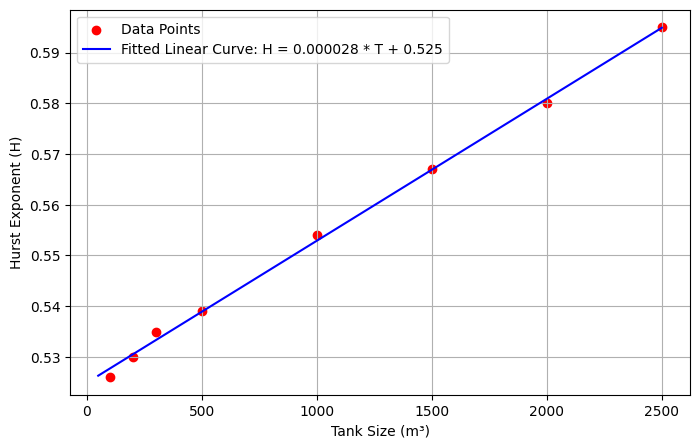

Fitted equation: H = 0.000028 * T + 0.525
R² value: 0.9982


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# New data points
tank_sizes = np.array([100, 200, 300, 500, 1000, 1500, 2000, 2500])
hurst_values = np.array([0.526, 0.530, 0.535, 0.539, 0.554, 0.567, 0.580, 0.595])

# Define a linear function
def linear_func(x, m, c):
    return m * x + c

# Fit the linear curve
popt, pcov = curve_fit(linear_func, tank_sizes, hurst_values)

# Generate smooth curve for plotting
x_fit = np.linspace(50, 2500, 100)
y_fit = linear_func(x_fit, *popt)

# Compute R²
y_pred = linear_func(tank_sizes, *popt)
ss_res = np.sum((hurst_values - y_pred) ** 2)
ss_tot = np.sum((hurst_values - np.mean(hurst_values)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

# Plot data points and fitted curve
plt.figure(figsize=(8, 5))
plt.scatter(tank_sizes, hurst_values, color='red', label="Data Points")
plt.plot(x_fit, y_fit, linestyle='-', color='blue', label=f"Fitted Linear Curve: H = {popt[0]:.6f} * T + {popt[1]:.3f}")
plt.xlabel("Tank Size (m³)")
plt.ylabel("Hurst Exponent (H)")
plt.grid(True)
plt.legend()
plt.show()

# Print the fitted parameters
m, c = popt
print(f"Fitted equation: H = {m:.6f} * T + {c:.3f}")
print(f"R² value: {r_squared:.4f}")


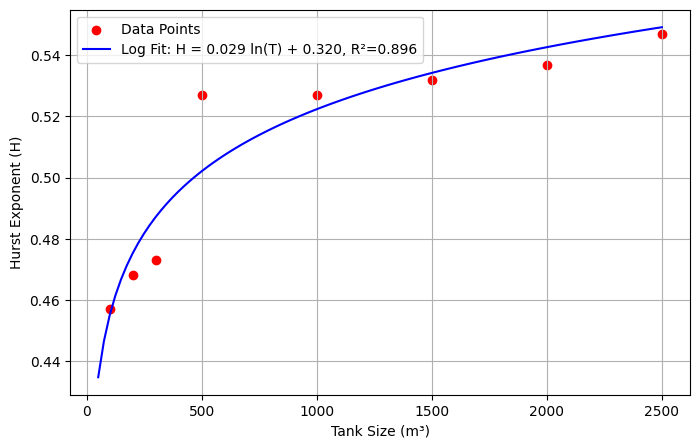

Log Fit: H = 0.029 ln(T) + 0.320, R²=0.896
Power Fit: H = 0.350 T^0.058, R²=0.892


In [60]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# New data points
tank_volumes = np.array([100, 200, 300, 500, 1000, 1500, 2000, 2500])

# Corresponding Hurst exponent values
hurst_values = np.array([0.457, 0.468, 0.473, 0.527, 0.527, 0.532, 0.537, 0.547])

# Logarithmic Fit
def log_func(x, a, b):
    return a * np.log(x) + b

popt_log, _ = curve_fit(log_func, tank_sizes, hurst_values)
hurst_pred_log = log_func(tank_sizes, *popt_log)
r2_log = r2_score(hurst_values, hurst_pred_log)

# Power-law function
def power_func(x, a, b):
    return a * (x ** b)

popt_power, _ = curve_fit(power_func, tank_sizes, hurst_values)
hurst_pred_power = power_func(tank_sizes, *popt_power)
r2_power = r2_score(hurst_values, hurst_pred_power)

# Generate smooth curves for plotting
x_fit = np.linspace(50, 2500, 100)
y_fit_log = log_func(x_fit, *popt_log)
y_fit_power = power_func(x_fit, *popt_power)

# Plot both fits
plt.figure(figsize=(8, 5))
plt.scatter(tank_sizes, hurst_values, color='red', label="Data Points")
plt.plot(x_fit, y_fit_log, linestyle='-', color='blue', label=f"Log Fit: H = {popt_log[0]:.3f} ln(T) + {popt_log[1]:.3f}, R²={r2_log:.3f}")
#plt.plot(x_fit, y_fit_power, linestyle='--', color='green', label=f"Power Fit: H = {popt_power[0]:.3f} T^{popt_power[1]:.3f}, R²={r2_power:.3f}")
plt.xlabel("Tank Size (m³)")
plt.ylabel("Hurst Exponent (H)")
plt.grid(True)
plt.legend()
plt.savefig("Hurst3.png", dpi=300, bbox_inches="tight")

plt.show()

# Print R² values and equations
a_log, b_log = popt_log
a_power, b_power = popt_power
print(f"Log Fit: H = {a_log:.3f} ln(T) + {b_log:.3f}, R²={r2_log:.3f}")
print(f"Power Fit: H = {a_power:.3f} T^{b_power:.3f}, R²={r2_power:.3f}")


In [28]:
combined_Qout = pd.read_pickle('combined_Qout_3.pkl')

In [19]:
combined_Qout

,Qout_notank,Qout_1000,Qout_2000,Qout_2500
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,2.043618e-08,0.000000e+00,0.000000e+00,0.000000e+00
3,2.366076e-03,1.175376e-03,1.175376e-03,1.175376e-03
4,3.353575e-03,1.665932e-03,1.665932e-03,1.665932e-03
...,...,...,...,...
525883,3.782714e-14,1.879124e-14,1.879124e-14,1.879124e-14
525884,1.578758e-14,7.842732e-15,7.842732e-15,7.842732e-15
525885,6.589121e-15,3.273251e-15,3.273251e-15,3.273251e-15
525886,2.750043e-15,1.366128e-15,1.366128e-15,1.366128e-15


### Second Try

Length of 2-year data: 105177
Vmax = 0 m3 - Estimated Hurst exponent (H): 0.471
Vmax = 500 m3 - Estimated Hurst exponent (H): 0.517
Vmax = 1000 m3 - Estimated Hurst exponent (H): 0.537
Vmax = 1500 m3 - Estimated Hurst exponent (H): 0.550
Vmax = 2000 m3 - Estimated Hurst exponent (H): 0.567
Vmax = 2500 m3 - Estimated Hurst exponent (H): 0.580
Vmax = 3000 m3 - Estimated Hurst exponent (H): 0.598
Vmax = 3500 m3 - Estimated Hurst exponent (H): 0.615


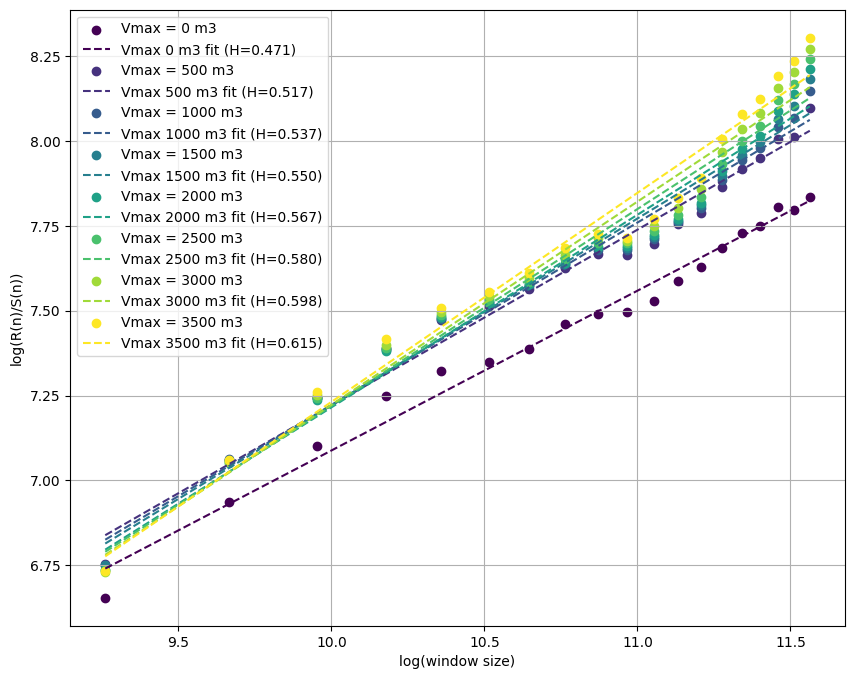

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pickle

# Load the stored Qout dictionary
with open("Qout_all.pkl", "rb") as f:
    Qout_all = pickle.load(f)

# Convert dictionary into a DataFrame for easier handling
combined_Qout = pd.DataFrame(Qout_all)

# --- Function to compute average R/S using vectorized operations ---
def average_rs_vectorized(series, n, step=1):
    """
    Compute the average R/S for a window of length n using vectorized operations.
    
    Parameters:
      series: Pandas Series of data.
      n: Window length (number of data points).
      step: Step size between windows.
      
    Returns:
      The average R/S computed over all overlapping segments.
    """
    arr = series.to_numpy()
    total_length = len(arr)
    num_windows = (total_length - n) // step + 1
    if num_windows < 1:
        return np.nan
    # Create a 2D view of overlapping segments
    shape = (num_windows, n)
    strides = (arr.strides[0] * step, arr.strides[0])
    windows = np.lib.stride_tricks.as_strided(arr, shape=shape, strides=strides)
    
    means = windows.mean(axis=1, keepdims=True)
    deviations = windows - means
    cumsum_dev = np.cumsum(deviations, axis=1)
    
    R_vals = cumsum_dev.max(axis=1) - cumsum_dev.min(axis=1)
    S_vals = windows.std(axis=1, ddof=1)
    valid = S_vals > 0
    if not np.any(valid):
        return np.nan
    RS_vals = R_vals[valid] / S_vals[valid]
    return RS_vals.mean()

# --- Restrict analysis to the first 5 years (20% of the total data) ---
data_5yr = combined_Qout.iloc[:len(combined_Qout)//5]
n_total_5 = len(data_5yr)
print(f"Length of 2-year data: {n_total_5}")

# --- Define window sizes ---
fractions = np.linspace(0.1, 1.0, 19)
window_sizes = np.floor(fractions * n_total_5).astype(int)

# --- Set up plot ---
plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(data_5yr.columns)))  # Generate unique colors

# --- Loop over all Vmax scenarios and compute Hurst exponent ---
for i, col in enumerate(data_5yr.columns):
    series = data_5yr[col]
    
    avg_rs_values = []
    valid_sizes = []
    
    step = max(1, n_total_5 // 100)
    
    for n in window_sizes:
        if n < 2:
            continue
        rs_val = average_rs_vectorized(series, n, step=step)
        if not np.isnan(rs_val):
            avg_rs_values.append(rs_val)
            valid_sizes.append(n)
            #print(f"Vmax {col} - Window size {n}: avg R/S = {rs_val:.3f}")
    
    # Convert to logarithms for regression
    log_n = np.log(valid_sizes)
    log_rs = np.log(avg_rs_values)
    
    # Perform linear regression on the log-log data
    slope, intercept, r_value, p_value, std_err = linregress(log_n, log_rs)
    H_est = slope
    print(f"Vmax = {col} m3 - Estimated Hurst exponent (H): {H_est:.3f}")
    
    # Plot the data points and regression line for this Vmax
    plt.scatter(log_n, log_rs, color=colors[i], label=f'Vmax = {col} m3')
    plt.plot(log_n, intercept + slope * log_n, color=colors[i],
             linestyle='--', label=f'Vmax {col} m3 fit (H={H_est:.3f})')

plt.xlabel('log(window size)')
plt.ylabel('log(R(n)/S(n))')
plt.legend()
plt.grid(True)
plt.savefig("Hurst_Qout_all.png", dpi=300, bbox_inches="tight")

plt.show()


Length of rainfall series: 525888
Length of 5-year rainfall data: 105177
Window size 10517: avg R/S = 694.219
Window size 15776: avg R/S = 941.923
Window size 21035: avg R/S = 1104.599
Window size 26294: avg R/S = 1243.045
Window size 31553: avg R/S = 1324.009
Window size 36811: avg R/S = 1336.418
Window size 42070: avg R/S = 1389.032
Window size 47329: avg R/S = 1507.867
Window size 52588: avg R/S = 1561.456
Window size 57847: avg R/S = 1564.265
Window size 63106: avg R/S = 1596.275
Window size 68365: avg R/S = 1697.137
Window size 73623: avg R/S = 1793.221
Window size 78882: avg R/S = 1917.988
Window size 84141: avg R/S = 1884.759
Window size 89400: avg R/S = 1878.050

Estimated Hurst exponent (H): 0.430


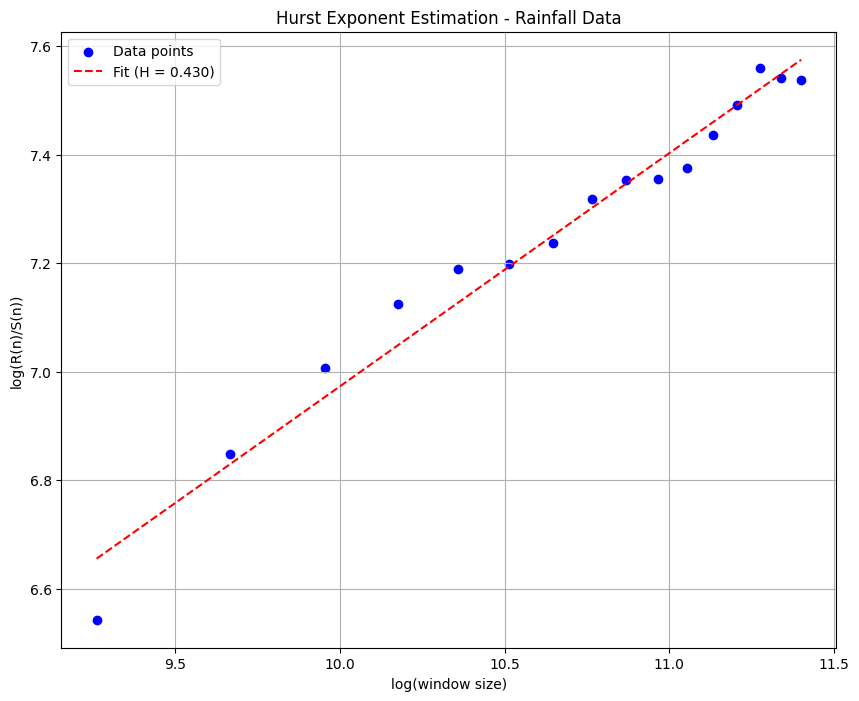

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assuming your rainfall series is already defined as:
switched_series = df_precp_10yr['switched_original_precp']
n_total = len(switched_series)
print(f"Length of rainfall series: {n_total}")

# --- Function to compute average R/S using vectorized operations ---
def average_rs_vectorized(series, n, step=1):
    """
    Compute the average R/S for a window of length n using vectorized operations.
    
    Parameters:
      series: Pandas Series of data.
      n: Window length (number of data points).
      step: Step size between windows.
      
    Returns:
      The average R/S computed over all overlapping segments.
    """
    arr = series.to_numpy()
    total_length = len(arr)
    num_windows = (total_length - n) // step + 1
    if num_windows < 1:
        return np.nan
    
    shape = (num_windows, n)
    strides = (arr.strides[0] * step, arr.strides[0])
    windows = np.lib.stride_tricks.as_strided(arr, shape=shape, strides=strides)
    
    means = windows.mean(axis=1, keepdims=True)
    deviations = windows - means
    cumsum_dev = np.cumsum(deviations, axis=1)
    
    R_vals = cumsum_dev.max(axis=1) - cumsum_dev.min(axis=1)
    S_vals = windows.std(axis=1, ddof=1)
    
    valid = S_vals > 0
    if not np.any(valid):
        return np.nan
    
    RS_vals = R_vals[valid] / S_vals[valid]
    
    return RS_vals.mean()

# --- Restrict analysis to the first 5 years (20% of the total data) ---
data_5yr = switched_series.iloc[:n_total // 5]
n_total_5 = len(data_5yr)
print(f"Length of 5-year rainfall data: {n_total_5}")

# --- Define window sizes ---
fractions = np.linspace(0.1, 1.0, 19)
window_sizes = np.floor(fractions * n_total_5).astype(int)

# --- Compute average R/S values over window sizes ---
avg_rs_values = []
valid_sizes = []

step = max(1, n_total_5 // 100)

for n in window_sizes:
    if n < 2:
        continue
    
    rs_val = average_rs_vectorized(data_5yr, n, step=step)
    
    if not np.isnan(rs_val):
        avg_rs_values.append(rs_val)
        valid_sizes.append(n)
        print(f"Window size {n}: avg R/S = {rs_val:.3f}")

# --- Convert to logarithms for regression ---
log_n = np.log(valid_sizes)
log_rs = np.log(avg_rs_values)

# --- Perform linear regression on the log-log data ---
slope, intercept, r_value, p_value, std_err = linregress(log_n, log_rs)
H_est = slope

print(f"\nEstimated Hurst exponent (H): {H_est:.3f}")

# --- Plot the R/S results and regression line ---
plt.figure(figsize=(10, 8))
plt.scatter(log_n, log_rs, color='blue', label='Data points')
plt.plot(log_n, intercept + slope * log_n, 'r--', label=f'Fit (H = {H_est:.3f})')

plt.xlabel('log(window size)')
plt.ylabel('log(R(n)/S(n))')
plt.title('Hurst Exponent Estimation - Rainfall Data')
plt.legend()
plt.grid(True)
plt.savefig("Hurst_Rainfall.png", dpi=300, bbox_inches="tight")

plt.show()


Length of 5-year data: 525888
Vmax 0 - Window size 52588: avg R/S = 1783.724
Vmax 0 - Window size 78883: avg R/S = 2207.372
Vmax 0 - Window size 105177: avg R/S = 2914.590
Vmax 0 - Window size 131472: avg R/S = 2949.831
Vmax 0 - Window size 157766: avg R/S = 2852.810
Vmax 0 - Window size 184060: avg R/S = 2838.172
Vmax 0 - Window size 210355: avg R/S = 3266.247
Vmax 0 - Window size 236649: avg R/S = 3677.058
Vmax 0 - Window size 262944: avg R/S = 4191.148
Vmax 0 - Window size 289238: avg R/S = 3839.378
Vmax 0 - Window size 315532: avg R/S = 4357.069
Vmax 0 - Window size 341827: avg R/S = 4208.645
Vmax 0 - Window size 368121: avg R/S = 4343.899
Vmax 0 - Window size 394416: avg R/S = 4580.099
Vmax 0 - Window size 420710: avg R/S = 4891.589
Vmax 0 - Window size 447004: avg R/S = 4322.295
Vmax 0 - Window size 473299: avg R/S = 4502.447
Vmax 0 - Window size 499593: avg R/S = 4125.173
Vmax 0 - Window size 525888: avg R/S = 5713.491
Vmax = 0 m3 - Estimated Hurst exponent (H): 0.422
Vmax 500 -

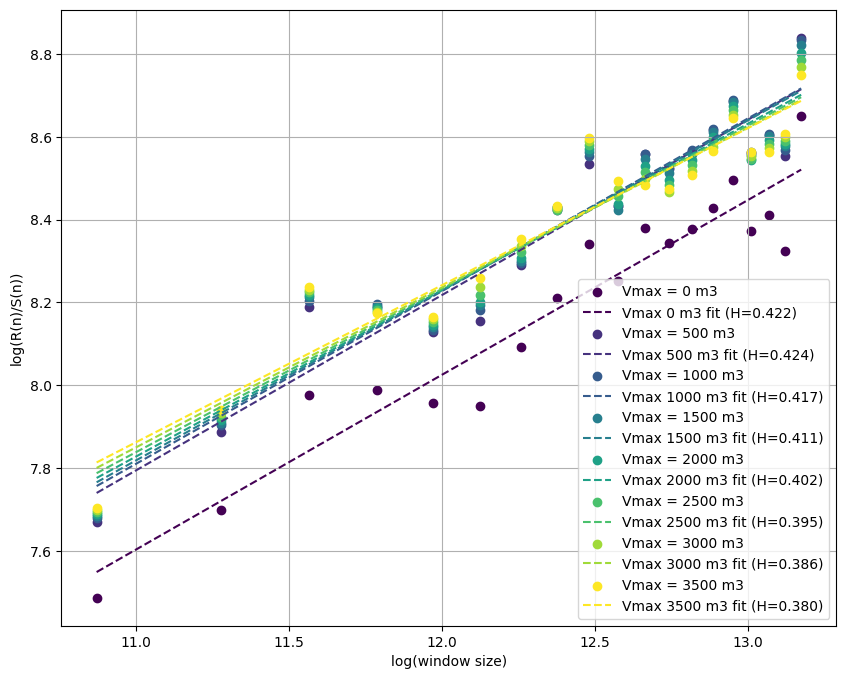

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pickle

# Load the stored Qout dictionary
with open("Qout_all.pkl", "rb") as f:
    Qout_all = pickle.load(f)

# Convert dictionary into a DataFrame for easier handling
combined_Qout = pd.DataFrame(Qout_all)

# --- Function to compute average R/S using vectorized operations (Non-Overlapping Windows) ---
def average_rs_non_overlapping(series, n):
    """
    Compute the average R/S for non-overlapping windows of length n.
    
    Parameters:
      series: Pandas Series of data.
      n: Window length (number of data points).
      
    Returns:
      The average R/S computed over all non-overlapping segments.
    """
    arr = series.to_numpy()
    total_length = len(arr)
    
    # Calculate number of complete windows that fit without overlap
    num_windows = total_length // n
    if num_windows < 1:
        return np.nan
    
    # Reshape the array to have 'num_windows' rows and 'n' columns
    trimmed_length = num_windows * n
    windows = arr[:trimmed_length].reshape(num_windows, n)
    
    means = windows.mean(axis=1, keepdims=True)
    deviations = windows - means
    cumsum_dev = np.cumsum(deviations, axis=1)
    
    R_vals = cumsum_dev.max(axis=1) - cumsum_dev.min(axis=1)
    S_vals = windows.std(axis=1, ddof=1)
    
    valid = S_vals > 0
    if not np.any(valid):
        return np.nan
    
    RS_vals = R_vals[valid] / S_vals[valid]
    
    return RS_vals.mean()


data = combined_Qout.iloc[:len(combined_Qout)]
n_total = len(data)
print(f"Length of 5-year data: {n_total}")

# --- Define window sizes ---
fractions = np.linspace(0.1, 1.0, 19)
window_sizes = np.floor(fractions * n_total).astype(int)

# Ensure window sizes are unique and greater than 1
window_sizes = np.unique(window_sizes)
window_sizes = window_sizes[window_sizes >= 2]

# --- Set up plot ---
plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(data.columns)))  # Generate unique colors

# --- Loop over all Vmax scenarios and compute Hurst exponent ---
for i, col in enumerate(data.columns):
    series = data[col]
    
    avg_rs_values = []
    valid_sizes = []
    
    for n in window_sizes:
        rs_val = average_rs_non_overlapping(series, n)
        if not np.isnan(rs_val):
            avg_rs_values.append(rs_val)
            valid_sizes.append(n)
            # Optional: print debug info
            print(f"Vmax {col} - Window size {n}: avg R/S = {rs_val:.3f}")
    
    # Convert to logarithms for regression
    log_n = np.log(valid_sizes)
    log_rs = np.log(avg_rs_values)
    
    # Perform linear regression on the log-log data
    slope, intercept, r_value, p_value, std_err = linregress(log_n, log_rs)
    H_est = slope
    print(f"Vmax = {col} m3 - Estimated Hurst exponent (H): {H_est:.3f}")
    
    # Plot the data points and regression line for this Vmax
    plt.scatter(log_n, log_rs, color=colors[i], label=f'Vmax = {col} m3')
    plt.plot(log_n, intercept + slope * log_n, color=colors[i],
             linestyle='--', label=f'Vmax {col} m3 fit (H={H_est:.3f})')

plt.xlabel('log(window size)')
plt.ylabel('log(R(n)/S(n))')
plt.legend()
plt.grid(True)
plt.savefig("Hurst_Qout_all_non_overlapping.png", dpi=300, bbox_inches="tight")

plt.show()


Vmax 0 - Fraction 0.1 - Window size 52588 - avg R/S = 1783.724
Vmax 0 - Fraction 0.2 - Window size 105177 - avg R/S = 2914.590
Vmax 0 - Fraction 0.3 - Window size 157766 - avg R/S = 3461.321
Vmax 0 - Fraction 0.4 - Window size 210355 - avg R/S = 4169.183
Vmax 0 - Fraction 0.5 - Window size 262944 - avg R/S = 4191.148
Vmax 0 - Fraction 0.6 - Window size 315532 - avg R/S = 4263.378
Vmax 0 - Fraction 0.7 - Window size 368121 - avg R/S = 4132.435
Vmax 0 - Fraction 0.8 - Window size 420710 - avg R/S = 5409.894
Vmax 0 - Fraction 0.9 - Window size 473299 - avg R/S = 4653.689
Vmax 0 - Fraction 1.0 - Window size 525888 - avg R/S = 5713.491
Vmax = 0 m3 - Estimated Hurst exponent (H): 0.440
Vmax 500 - Fraction 0.1 - Window size 52588 - avg R/S = 2143.486
Vmax 500 - Fraction 0.2 - Window size 105177 - avg R/S = 3598.273
Vmax 500 - Fraction 0.3 - Window size 157766 - avg R/S = 4201.270
Vmax 500 - Fraction 0.4 - Window size 210355 - avg R/S = 5185.496
Vmax 500 - Fraction 0.5 - Window size 262944 - a

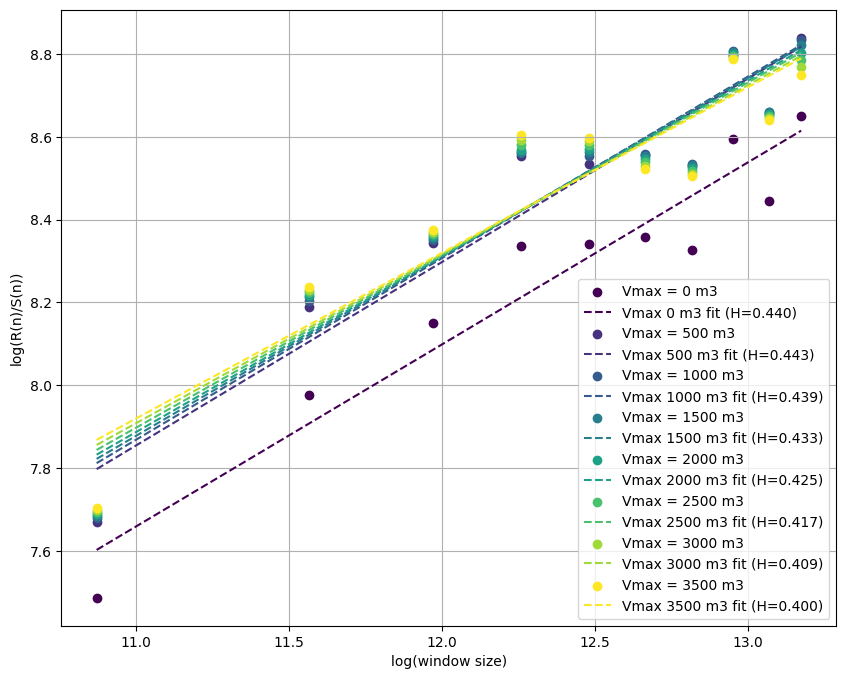

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pickle

# Load Qout dictionary and convert it to DataFrame
with open("Qout_all.pkl", "rb") as f:
    Qout_all = pickle.load(f)

combined_Qout = pd.DataFrame(Qout_all)

# --- Function to compute R/S for custom windows ---
def custom_rs(series, fraction, n_total):
    """
    Compute average R/S for a specific fraction of the data
    following custom rules for number of windows and overlap.
    """
    # Window size (fraction of total data)
    window_size = int(fraction * n_total)

    # Define number of windows and overlap rules
    if fraction == 0.1:
        num_windows = 10
        overlap = False
    elif fraction == 0.2:
        num_windows = 5
        overlap = False
    elif fraction == 0.3:
        num_windows = 3
        overlap = False
    elif fraction == 0.4:
        num_windows = 2
        overlap = False
    elif fraction == 0.5:
        num_windows = 2
        overlap = False
    elif fraction >= 0.6 and fraction <= 0.9:
        num_windows = 2
        overlap = True  # minimal overlap
    elif fraction == 1.0:
        num_windows = 1
        overlap = False
    else:
        return np.nan  # Fallback

    # List to store R/S values from each window
    rs_values = []

    # --- No Overlap ---
    if not overlap:
        step = (n_total - window_size) // (num_windows - 1) if num_windows > 1 else 0
        for i in range(num_windows):
            start_idx = i * step
            end_idx = start_idx + window_size
            if end_idx > n_total:
                break  # Don't go out of bounds
            rs = rs_calculation(series[start_idx:end_idx])
            if not np.isnan(rs):
                rs_values.append(rs)

    # --- Minimal Overlap ---
    else:
        # Goal: place two windows with minimal overlap
        overlap_length = int(0.1 * n_total)  # 10% overlap of total data
        start_1 = 0
        end_1 = start_1 + window_size

        start_2 = end_1 - overlap_length
        end_2 = start_2 + window_size

        # Adjust second window if it goes beyond the data length
        if end_2 > n_total:
            end_2 = n_total
            start_2 = end_2 - window_size

        # Ensure start indices are valid
        if end_1 <= n_total:
            rs1 = rs_calculation(series[start_1:end_1])
            if not np.isnan(rs1):
                rs_values.append(rs1)
        if start_2 >= 0 and end_2 <= n_total:
            rs2 = rs_calculation(series[start_2:end_2])
            if not np.isnan(rs2):
                rs_values.append(rs2)

    # Return the mean R/S across the windows
    if len(rs_values) > 0:
        return np.mean(rs_values)
    else:
        return np.nan

# --- Function to calculate R/S for one window (basic version) ---
def rs_calculation(window):
    """
    Calculate R/S for a single window (1D array).
    """
    window = np.array(window)
    if len(window) < 2:
        return np.nan
    mean = np.mean(window)
    deviations = window - mean
    cumsum_dev = np.cumsum(deviations)
    R = np.max(cumsum_dev) - np.min(cumsum_dev)
    S = np.std(window, ddof=1)
    if S == 0:
        return np.nan
    return R / S

# --- Main analysis ---
data = combined_Qout
n_total = len(data)

# Fractions as per your rule
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# --- Set up plot ---
plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(data.columns)))  # Unique colors

# --- Loop over all Vmax scenarios and compute Hurst exponent ---
for i, col in enumerate(data.columns):
    series = data[col]
    
    avg_rs_values = []
    valid_window_sizes = []

    for frac in fractions:
        rs_val = custom_rs(series, frac, n_total)
        if not np.isnan(rs_val):
            avg_rs_values.append(rs_val)
            window_size = int(frac * n_total)
            valid_window_sizes.append(window_size)
            print(f"Vmax {col} - Fraction {frac:.1f} - Window size {window_size} - avg R/S = {rs_val:.3f}")

    # Convert to logarithms for regression
    log_n = np.log(valid_window_sizes)
    log_rs = np.log(avg_rs_values)

    # Perform linear regression on log-log data
    slope, intercept, r_value, p_value, std_err = linregress(log_n, log_rs)
    H_est = slope
    print(f"Vmax = {col} m3 - Estimated Hurst exponent (H): {H_est:.3f}")

    # Plot the data points and regression line for this Vmax
    plt.scatter(log_n, log_rs, color=colors[i], label=f'Vmax = {col} m3')
    plt.plot(log_n, intercept + slope * log_n, color=colors[i], linestyle='--', label=f'Vmax {col} m3 fit (H={H_est:.3f})')

plt.xlabel('log(window size)')
plt.ylabel('log(R(n)/S(n))')
plt.legend()
plt.grid(True)
plt.savefig("Hurst_Qout_all_custom_windows.png", dpi=300, bbox_inches="tight")
plt.show()
